# KNN classification

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [13]:
np.random.seed(42)

In [14]:
# KNN Classifier class
class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def euclidean_distance(self, x1, x2):   # cartesian coordinate plane: distance formula
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        predictions = []
        for x in X:
            # Compute distances to all training samples
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
            # Get indices of k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            # Get labels of k nearest neighbors
            k_labels = self.y_train[k_indices]
            # Majority voting
            most_common = Counter(k_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

In [16]:
# Load dataset
df = pd.read_csv('../dataset/satellite_signal_dataset.csv')
df.head()

,orbit_type,distance_m,frequency_hz,transmit_power_dbw,transmit_antenna_diameter_m,receive_antenna_diameter_m,rain_rate_mmhr,atmospheric_loss_db,pointing_error_deg,bandwidth_hz,...,transmit_antenna_gain_db,receive_antenna_gain_db,fspl_db,rain_attenuation_db,pointing_loss_db,transmit_power_dbm,received_power_dbm,noise_power_dbm,cn_ratio_db,signal_quality
0,GEO,3.565755e+07,1.626957e+09,24.599966,1.097824,2.302199,8.523263,1.951948,0.057916,2.376473e+07,...,23.220260,29.652463,187.712322,0.046653,0.001281,54.599966,-82.239514,-101.064908,18.825394,Good
1,MEO,1.153046e+07,2.732246e+10,13.690240,0.689636,2.678975,0.784847,1.817429,0.000000,2.574373e+07,...,43.684873,55.471854,202.409099,2.781469,0.000000,43.690240,-64.161030,-100.093471,35.932441,Good
2,LEO,8.547917e+05,6.435908e+09,16.932794,0.752718,1.550586,14.636986,1.377592,0.080622,4.398066e+07,...,31.886933,38.164197,167.251175,0.163628,0.017614,46.932794,-51.826086,-101.616579,49.790493,Good
3,LEO,6.793379e+05,2.754270e+10,23.265613,0.861342,1.080783,9.264690,1.733032,1.207310,2.521968e+06,...,45.685729,47.656980,177.883618,1.511315,35.145513,53.265613,-69.665155,-110.930365,41.265211,Good
4,GEO,3.586736e+07,1.499221e+10,19.641787,0.907307,1.160886,12.557483,1.412742,0.000000,2.388476e+07,...,40.854477,42.995185,207.053070,45.040371,0.000000,49.641787,-120.014733,-103.200321,-16.814412,Poor


In [17]:
# Encoding categorical 'orbit_type'...
df = pd.get_dummies(df, columns=['orbit_type'], prefix='orbit')

In [19]:
# Converting boolean columns to integer
for col in ['orbit_GEO', 'orbit_LEO', 'orbit_MEO']:
    if col in df.columns:
        df[col] = df[col].astype(int)

In [20]:
# Defining features and target...
features = [col for col in df.columns if col != 'signal_quality']
X = df[features].values
y = df['signal_quality'].map({'Good': 2, 'Moderate': 1, 'Poor': 0}).values

In [21]:
# Standardizing features..
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_std[X_std == 0] = 1  
X = (X - X_mean) / X_std

In [22]:
# test-train split...
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
train_size = int(0.8 * n_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [23]:
# applyig KNN...
model = KNN(k=5)
model.fit(X_train, y_train)

In [24]:
# Predict on test data
y_pred = model.predict(X_test)

In [25]:
# Evaluating model 🎯
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9370


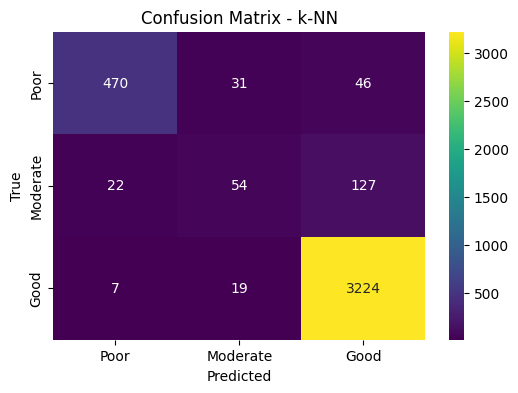

In [27]:
# confusion matrix
num_classes = 3
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true, pred in zip(y_test, y_pred):
    conf_matrix[true, pred] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Poor', 'Moderate', 'Good'],
            yticklabels=['Poor', 'Moderate', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - k-NN')
plt.show()

In [30]:
# Create a mapping from numerical predictions back to original labels
label_mapping = {2: 'Good', 1: 'Moderate', 0: 'Poor'}
y_pred_labels = [label_mapping[pred] for pred in y_pred]
y_test_labels = [label_mapping[true] for true in y_test]

# Create a DataFrame with the true and predicted labels
predictions_df = pd.DataFrame({'True_label': y_test_labels, 'Predicted_label': y_pred_labels})

# Save the DataFrame to a CSV file
predictions_df.to_csv('../predictions/knn_predictions.csv', index=False)

print("Predictions saved to knn_predictions.csv")

Predictions saved to knn_predictions.csv
